In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import gymnasium as gym
import gym_trading_env
import math
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [2]:
path=r"C:\Users\HP\Desktop\RL2\btc_6h.csv"
data=pd.read_csv(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
long_sma_window = 50
short_sma_window = 20
data['feature_Long_SMA'] = data['close'].rolling(window=long_sma_window, min_periods=1).mean()
data['feature_Short_SMA'] = data['close'].rolling(window=short_sma_window, min_periods=1).mean()
data['feature_RSI'] = ta.momentum.rsi(close=data['close'], window=14)
data["feature_close"] = data["close"].pct_change()
data["feature_open"] = data["open"]/data["close"]
data["feature_high"] = data["high"]/data["close"]
data["feature_low"] = data["low"]/data["close"]
data["feature_volume"] = data["volume"] / data["volume"].rolling(7*24).max()

In [4]:
data.dropna(inplace=True)
data['date'] = pd.to_datetime(data['date_str'])
data.set_index('date', inplace=True)
data

,date_str,open,high,low,close,volume,feature_Long_SMA,feature_Short_SMA,feature_RSI,feature_close,feature_open,feature_high,feature_low,feature_volume
date,,,,,,,,,,,,,,
2018-02-12 23:30:00,2018-02-12 23:30:00,8768.01,8989.00,8639.24,8903.00,10317.674120,8571.8046,8321.7780,57.584590,0.015389,0.984838,1.009660,0.970374,0.356490
2018-02-13 05:30:00,2018-02-13 05:30:00,8903.00,8950.00,8554.87,8629.95,9878.667870,8539.7036,8382.2750,53.059210,-0.030669,1.031640,1.037086,0.991300,0.341321
2018-02-13 11:30:00,2018-02-13 11:30:00,8625.35,8759.00,8351.00,8531.47,11148.685391,8505.5828,8401.2720,51.487610,-0.011411,1.011004,1.026669,0.978847,0.385202
2018-02-13 17:30:00,2018-02-13 17:30:00,8525.08,8680.00,8450.00,8622.66,7723.422882,8476.0910,8418.1905,52.879407,0.010689,0.988683,1.006650,0.979976,0.266855
2018-02-13 23:30:00,2018-02-13 23:30:00,8616.08,8725.00,8461.00,8539.90,6704.196813,8441.0880,8465.2355,51.437100,-0.009598,1.008920,1.021675,0.990761,0.231639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-30 05:30:00,2022-01-30 05:30:00,38166.83,38300.00,37737.49,38139.39,4656.397760,38065.3980,37240.6265,55.394484,-0.000719,1.000719,1.004211,0.989462,0.123947
2022-01-30 11:30:00,2022-01-30 11:30:00,38139.38,38359.26,37795.00,38110.02,6113.435610,37983.5660,37325.8275,55.147056,-0.000770,1.000770,1.006540,0.991734,0.162732
2022-01-30 17:30:00,2022-01-30 17:30:00,38110.03,38153.82,37712.05,37991.00,4075.221880,37901.4410,37361.7110,54.092619,-0.003123,1.003133,1.004286,0.992657,0.108477


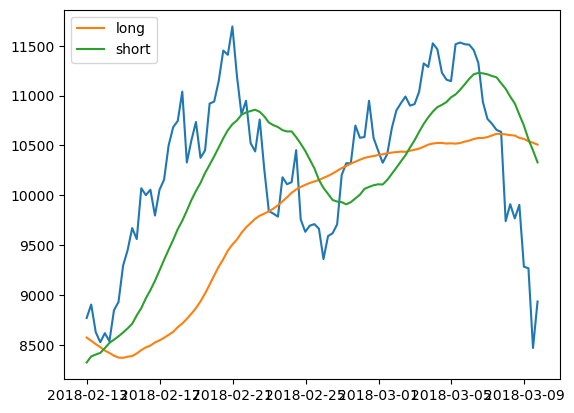

In [5]:
plt.plot(data['open'][0:100])
plt.plot(data['feature_Long_SMA'][0:100],label='long')
plt.plot(data['feature_Short_SMA'][0:100],label='short')
plt.legend()

In [6]:
#Actions are positions
# 1 : All of our portfolio is converted into BTC. (=BUY ALL)
# 0 : All of our portfolio is converted into USD. (=SELL ALL)
# Now, we can imagine half position and other variants :
# 0.5 : 50% in BTC & 50% in USD
# Even : 0.1 : 10% in BTC & 90% in USD ….
env = gym.make("TradingEnv",
        name= "BTCUSD",
        df = data,
        positions = [ 0,0.2,0.4,0.6,0.8,1], #0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy
        borrow_interest_rate= 0.0003/100, 
    )

In [7]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [1]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return (policy_net(state)).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
    
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 5:
        means = durations_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

NameError: name 'env' is not defined

: 

In [19]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    print(batch)
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    print(state_batch,action_batch,reward_batch)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    print(state_action_values)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


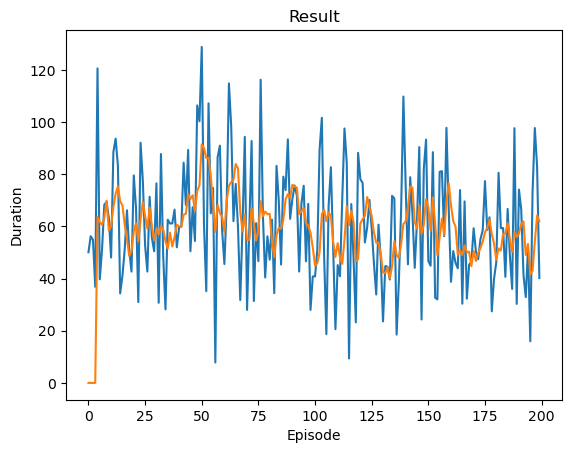

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 200

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        if(ran):
            target_net_state_dict = target_net_2.state_dict()
            policy_net_state_dict = policy_net_2.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net_2.load_state_dict(target_net_state_dict)
        else:
            target_net_state_dict = target_net_1.state_dict()
            policy_net_state_dict = policy_net_1.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net_1.load_state_dict(target_net_state_dict)

        if done:
            dict=env.unwrapped.get_metrics()
            env.unwrapped.save_for_render(dir = "render_logs")
            p=float(dict['Portfolio Return'][0:-1])
            episode_durations.append(p)
            print(episode_durations)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()